In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# File paths
file_paths = {
    "circuits": "circuits.csv",
    "constructor_results": "constructor_results.csv",
    "constructor_standings": "constructor_standings.csv",
    "constructors": "constructors.csv",
    "driver_standings": "driver_standings.csv",
    "drivers": "drivers.csv",
    "lap_times": "lap_times.csv",
    "pit_stops": "pit_stops.csv",
    "qualifying": "qualifying.csv",
    "races": "races.csv",
    "results": "results.csv",
    "seasons": "seasons.csv",
    "sprint_results": "sprint_results.csv",
    "status": "status.csv",
}

# Load all datasets into a dictionary
dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Display dataset info
for name, df in dfs.items():
    print(f"{name.upper()} dataset - Shape: {df.shape}")
    print(df.info(), "\n", "="*80, "\n")


CIRCUITS dataset - Shape: (77, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   name        77 non-null     object 
 3   location    77 non-null     object 
 4   country     77 non-null     object 
 5   lat         77 non-null     float64
 6   lng         77 non-null     float64
 7   alt         77 non-null     int64  
 8   url         77 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.5+ KB
None 

CONSTRUCTOR_RESULTS dataset - Shape: (12625, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12625 entries, 0 to 12624
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   constructorResultsId  12625 non-null  int64  
 1   raceId                12625 no

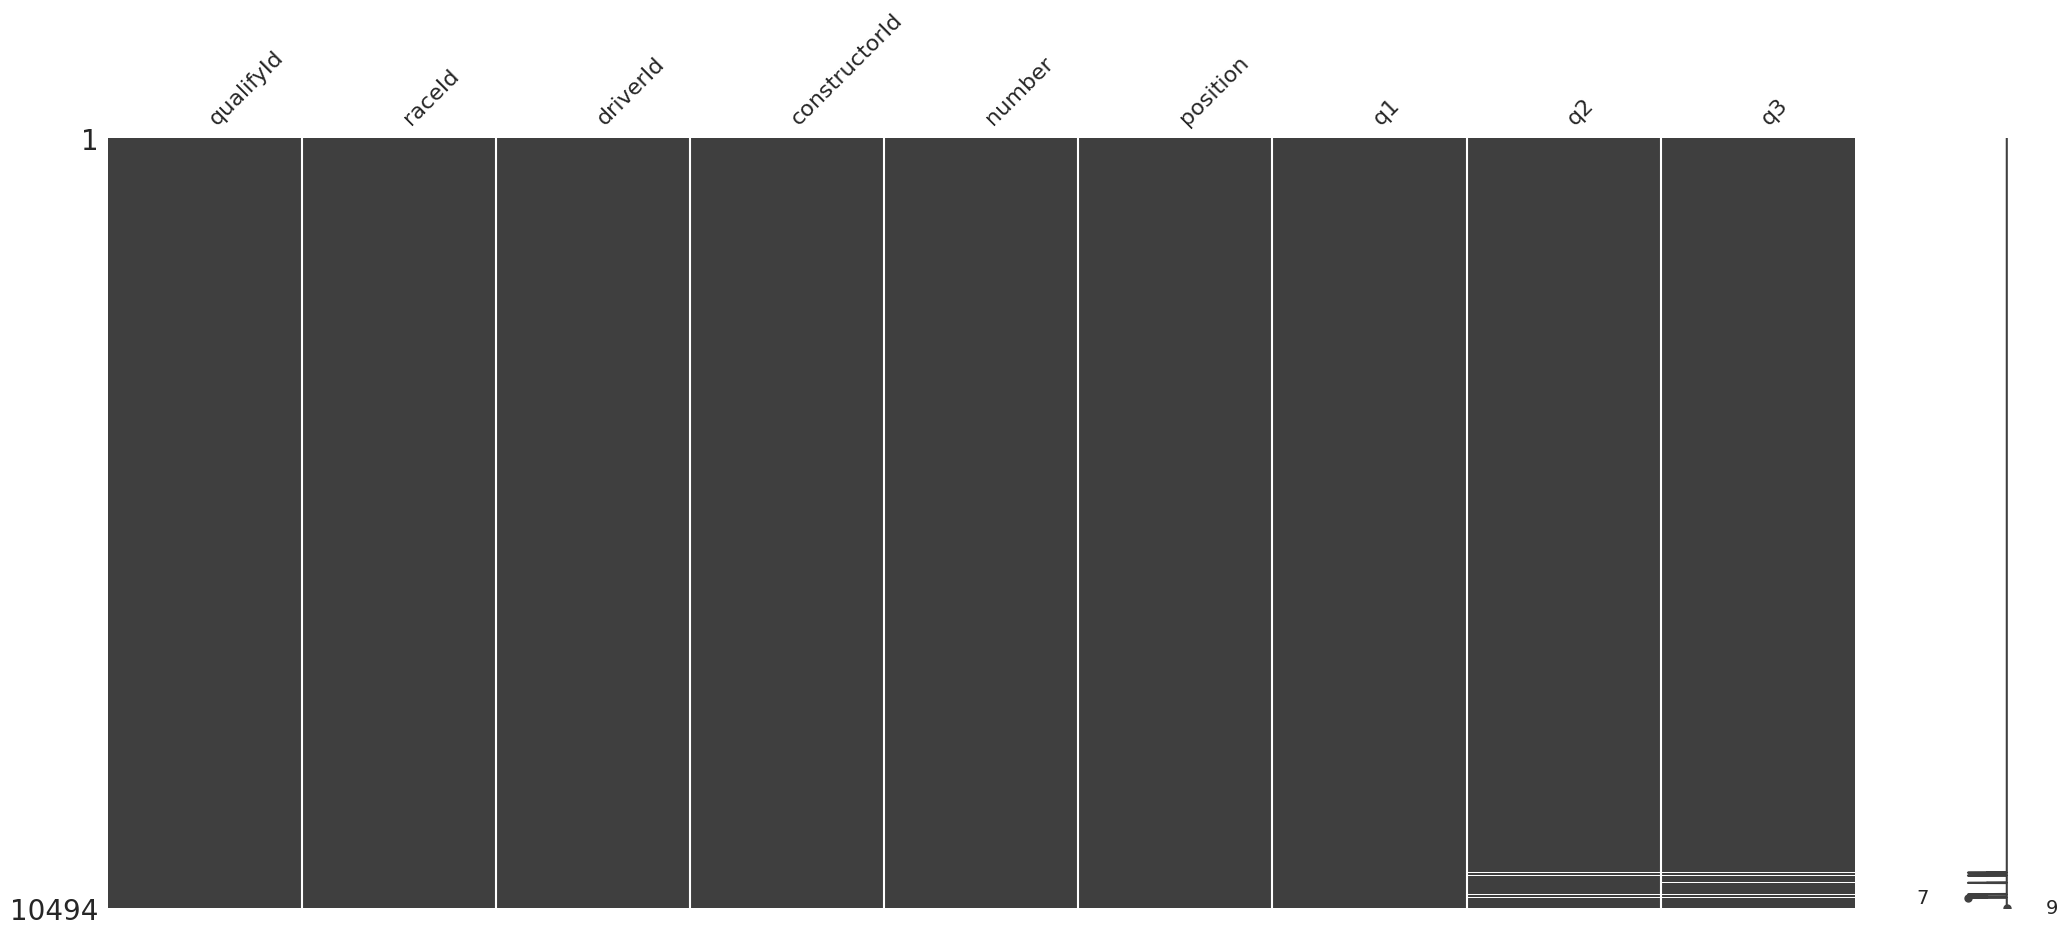

qualifyId        0
raceId           0
driverId         0
constructorId    0
number           0
position         0
q1               0
q2               0
q3               0
dtype: int64


<ipython-input-23-ee807f7ff664>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfs["qualifying"][["q2", "q3"]] = dfs["qualifying"][["q2", "q3"]].fillna(method='ffill')


In [ ]:
# Visualize missing values
msno.matrix(dfs["qualifying"])
plt.show()

# Fill missing qualifying times by propagating previous round times
dfs["qualifying"][["q2", "q3"]] = dfs["qualifying"][["q2", "q3"]].fillna(method='ffill')

# Verify missing values are handled
print(dfs["qualifying"].isnull().sum())


In [ ]:
# Count unique values for key identifiers
key_columns = {
    "driverId": ["driver_standings", "drivers", "lap_times", "pit_stops", "qualifying", "results", "sprint_results"],
    "constructorId": ["constructor_results", "constructor_standings", "constructors", "qualifying", "results", "sprint_results"],
    "circuitId": ["circuits", "races"],
    "raceId": ["constructor_results", "constructor_standings", "driver_standings", "lap_times", "pit_stops", "qualifying", "races", "results", "sprint_results"],
    "statusId": ["results", "sprint_results", "status"]
}

for col, datasets in key_columns.items():
    print(f"Unique values in {col}:")
    for dataset in datasets:
        if col in dfs[dataset].columns:
            print(f"{dataset}: {dfs[dataset][col].nunique()}")
    print("\n" + "="*80 + "\n")


Unique values in driverId:
driver_standings: 854
drivers: 861
lap_times: 143
pit_stops: 76
qualifying: 172
results: 861
sprint_results: 31


Unique values in constructorId:
constructor_results: 175
constructor_standings: 160
constructors: 212
qualifying: 47
results: 211
sprint_results: 12


Unique values in circuitId:
circuits: 77
races: 77


Unique values in raceId:
constructor_results: 1060
constructor_standings: 1061
driver_standings: 1125
lap_times: 544
pit_stops: 285
qualifying: 494
races: 1125
results: 1125
sprint_results: 18


Unique values in statusId:
results: 137
sprint_results: 8
status: 139




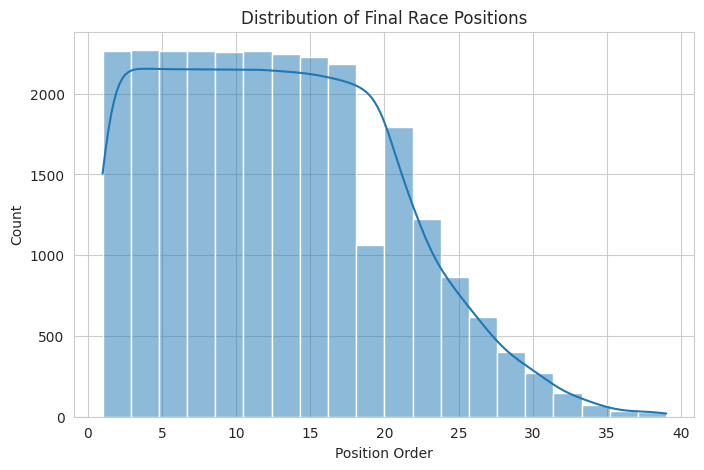

<ipython-input-25-8c17044c3f1a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="year", data=winners, palette="coolwarm")


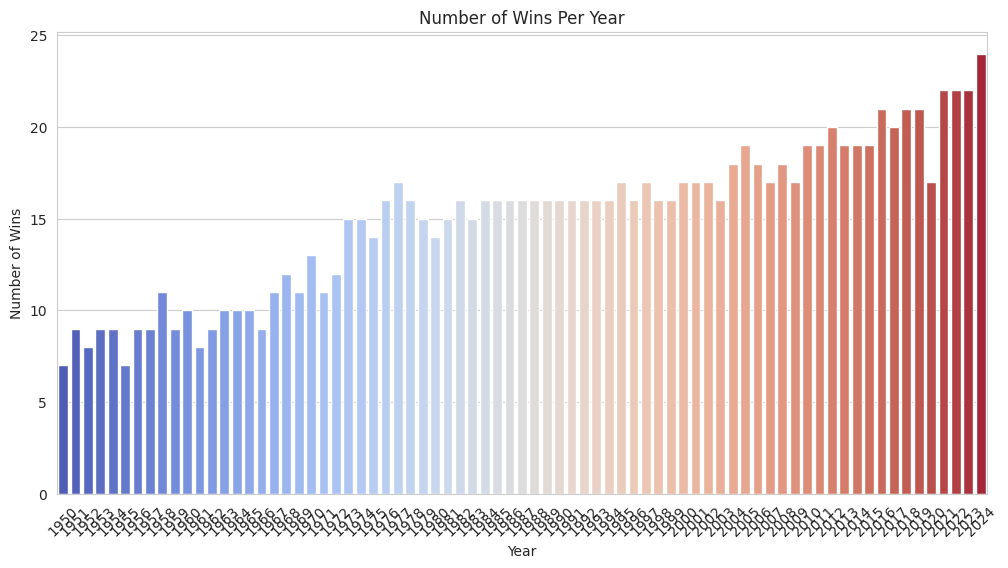

In [ ]:
# Set visualization style
sns.set_style("whitegrid")

# Histogram: Race positions
plt.figure(figsize=(8, 5))
sns.histplot(dfs["results"]["positionOrder"].dropna(), bins=20, kde=True)
plt.xlabel("Position Order")
plt.ylabel("Count")
plt.title("Distribution of Final Race Positions")
plt.show()

# Countplot: Winners per year
if "races" in dfs and "results" in dfs:
    merged = dfs["races"].merge(dfs["results"], on="raceId", how="inner")
    winners = merged[merged["positionOrder"] == 1]

    plt.figure(figsize=(12, 6))
    sns.countplot(x="year", data=winners, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Number of Wins")
    plt.title("Number of Wins Per Year")
    plt.show()


In [ ]:
# Merge results with races to get year
driver_performance = dfs["results"].merge(dfs["races"][["raceId", "year"]], on="raceId", how="left")

# Aggregate driver statistics
driver_features = driver_performance.groupby(["driverId", "year"]).agg(
    avg_finishing_position=("positionOrder", "mean"),
    total_podiums=("positionOrder", lambda x: (x <= 3).sum()),
    total_wins=("positionOrder", lambda x: (x == 1).sum()),
    avg_grid_position=("grid", "mean"),
    fastest_lap_count=("rank", lambda x: (x == 1).sum())
).reset_index()

# Fill NaN values with 0
driver_features.fillna(0, inplace=True)

driver_features.head()


,driverId,year,avg_finishing_position,total_podiums,total_wins,avg_grid_position,fastest_lap_count
0,1,2007,3.941176,12,4,2.588235,0
1,1,2008,5.222222,10,5,3.888889,0
2,1,2009,9.705882,5,2,9.176471,0
3,1,2010,6.421053,9,3,5.157895,0
4,1,2011,6.736842,6,3,3.578947,0


In [ ]:
# Aggregate constructor statistics
constructor_features = driver_performance.groupby(["constructorId", "year"]).agg(
    avg_finishing_position=("positionOrder", "mean"),
    total_podiums=("positionOrder", lambda x: (x <= 3).sum()),
    total_wins=("positionOrder", lambda x: (x == 1).sum()),
    fastest_lap_count=("rank", lambda x: (x == 1).sum())
).reset_index()

constructor_features.fillna(0, inplace=True)

constructor_features.head()


,constructorId,year,avg_finishing_position,total_podiums,total_wins,fastest_lap_count
0,1,1968,10.500000,0,0,0
1,1,1971,14.148148,1,0,0
2,1,1972,6.680000,11,1,0
3,1,1973,8.742857,8,3,0
4,1,1974,9.326087,10,4,0


In [ ]:
# Convert milliseconds to numeric
dfs["results"]["milliseconds"] = pd.to_numeric(dfs["results"]["milliseconds"], errors="coerce")
dfs["results"]["milliseconds"].fillna(dfs["results"]["milliseconds"].mean(), inplace=True)

# Aggregate race track difficulty
race_features = dfs["results"].merge(dfs["races"], on="raceId", how="left").groupby("circuitId").agg(
    avg_race_time=("milliseconds", "mean"),
    avg_grid_position=("grid", "mean"),
    avg_finishing_position=("positionOrder", "mean")
).reset_index()

# Overtaking index
race_features["overtaking_index"] = race_features["avg_grid_position"] - race_features["avg_finishing_position"]

race_features.head()


<ipython-input-28-8453fabd7838>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfs["results"]["milliseconds"].fillna(dfs["results"]["milliseconds"].mean(), inplace=True)


,circuitId,avg_race_time,avg_grid_position,avg_finishing_position,overtaking_index
0,1,6.011876e+06,10.954939,11.242634,-0.287695
1,2,6.136978e+06,11.330097,11.383495,-0.053398
2,3,6.024960e+06,10.993182,11.018182,-0.025000
3,4,6.054255e+06,11.260870,11.893281,-0.632411
4,5,5.805630e+06,11.031250,11.229167,-0.197917


In [ ]:
# Merge all features into a final dataset
# Include 'constructorId' in the driver_features aggregation
driver_features = driver_performance.groupby(["driverId", "constructorId", "year"]).agg(
    avg_finishing_position=("positionOrder", "mean"),
    total_podiums=("positionOrder", lambda x: (x <= 3).sum()),
    total_wins=("positionOrder", lambda x: (x == 1).sum()),
    avg_grid_position=("grid", "mean"),
    fastest_lap_count=("rank", lambda x: (x == 1).sum())
).reset_index()

final_df = driver_features.merge(constructor_features, on=["year", "constructorId"], how="left")
final_df = final_df.merge(dfs["results"][["raceId", "driverId", "constructorId", "positionOrder"]], on=["driverId", "constructorId"], how="left")
final_df = final_df.merge(dfs["races"][["raceId", "year", "circuitId"]], on="raceId", how="left")
final_df = final_df.merge(race_features, on="circuitId", how="left")

# Merge driver standings (points and championship position)
final_df = final_df.merge(dfs["driver_standings"][["driverId", "raceId", "points", "position"]], on=["driverId", "raceId"], how="left")

# Cleanup
final_df.drop(columns=["raceId"], inplace=True)
final_df.fillna(0, inplace=True)
final_df.to_csv("final_df.csv",index="False")
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86622 entries, 0 to 86621
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   driverId                  86622 non-null  int64  
 1   constructorId             86622 non-null  int64  
 2   year_x                    86622 non-null  int64  
 3   avg_finishing_position_x  86622 non-null  float64
 4   total_podiums_x           86622 non-null  int64  
 5   total_wins_x              86622 non-null  int64  
 6   avg_grid_position_x       86622 non-null  float64
 7   fastest_lap_count_x       86622 non-null  int64  
 8   avg_finishing_position_y  86622 non-null  float64
 9   total_podiums_y           86622 non-null  int64  
 10  total_wins_y              86622 non-null  int64  
 11  fastest_lap_count_y       86622 non-null  int64  
 12  positionOrder             86622 non-null  int64  
 13  year_y                    86622 non-null  int64  
 14  circui

In [ ]:
driver_features = driver_performance.groupby(["driverId", "constructorId", "year"]).agg(
    avg_finishing_position=("positionOrder", "mean"),
    total_podiums=("positionOrder", lambda x: (x <= 3).sum()),
    total_wins=("positionOrder", lambda x: (x == 1).sum()),
    avg_grid_position=("grid", "mean"),
    fastest_lap_count=("rank", lambda x: (x == 1).sum())
).reset_index()
print("Driver Features Columns:", driver_features.columns)
print("Constructor Features Columns:", constructor_features.columns)


Driver Features Columns: Index(['driverId', 'constructorId', 'year', 'avg_finishing_position',
       'total_podiums', 'total_wins', 'avg_grid_position',
       'fastest_lap_count'],
      dtype='object')
Constructor Features Columns: Index(['constructorId', 'year', 'avg_finishing_position', 'total_podiums',
       'total_wins', 'fastest_lap_count'],
      dtype='object')


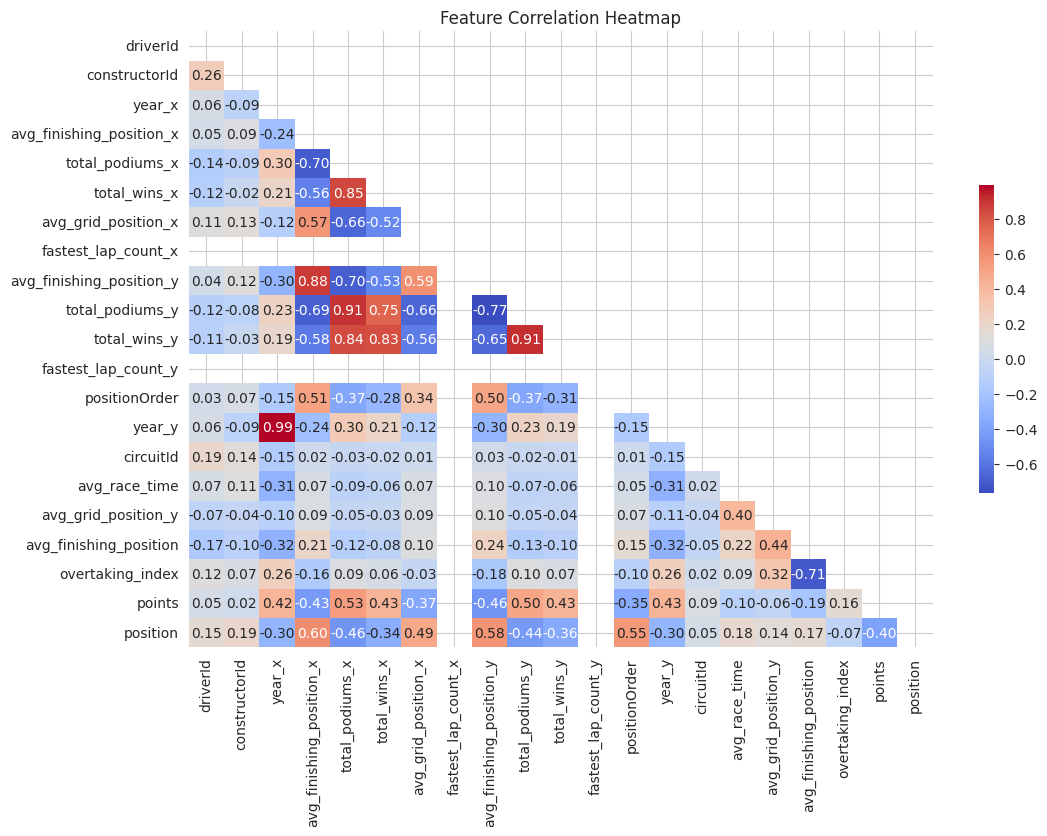

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = final_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", mask=mask, cbar_kws={'shrink': 0.5})
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Drop non-relevant columns (IDs, categorical features that are not useful for modeling)
drop_cols = ["driverId", "constructorId", "circuitId"]
X = final_df.drop(columns=drop_cols + ["positionOrder"])  # Drop target variable
y = final_df["positionOrder"]  # Target variable: Position in race

# Standardize numerical features (for models that need scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n {model_name} Performance:")
    print(f" MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f" MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f" R² Score: {r2_score(y_true, y_pred):.4f}")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")



 Random Forest Performance:
 MAE: 3.1126
 MSE: 18.4086
 R² Score: 0.6761

 XGBoost Performance:
 MAE: 4.2873
 MSE: 29.5592
 R² Score: 0.4800


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                 n_iter=10, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf, "Optimized Random Forest")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor([
    ('rf', best_rf),
    ('xgb', xgb_model)
])
ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
evaluate_model(y_test, y_pred_ensemble, "Ensemble Model")


NameError: name 'best_rf' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor()

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(xgb_model, param_dist, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, n_iter=20)
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_


In [ ]:
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

print("Optimized Random Forest:")
evaluate_model(y_test, y_pred_rf)

print("Optimized XGBoost:")
evaluate_model(y_test, y_pred_xgb)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'positionOrder' is the target column in your 'final_df'
target_col = 'positionOrder'
X = final_df.drop(columns=[target_col])  # Features
y = final_df[target_col]  # Target

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (69297, 20)
Testing set size: (17325, 20)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best parameters
best_rf_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_optimized = best_rf_model.predict(X_test)

# Evaluate performance
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MAE: {mae_optimized:.2f}")
print(f"Optimized R² Score: {r2_optimized:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Convert predictions to integer positions (rounded)
y_pred_rounded = np.round(y_pred).astype(int)

# Rank positions to resolve ties
sorted_indices = np.argsort(y_pred)  # Get indices of sorted predictions
final_positions = np.zeros_like(y_pred_rounded)

for rank, index in enumerate(sorted_indices, start=1):
    final_positions[index] = rank


In [ ]:
# Get test driver IDs (assuming we have 'driverId' in X_test)
test_driver_ids = df.iloc[X_test.index]['driverId'].values  # Adjust if needed

# Create a dataframe with predicted standings
predicted_results = pd.DataFrame({
    'Driver ID': test_driver_ids,
    'Predicted Position': final_positions
})

# Sort by predicted position
predicted_results = predicted_results.sort_values(by="Predicted Position")

print(predicted_results)


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 2.65
R² Score: 0.75


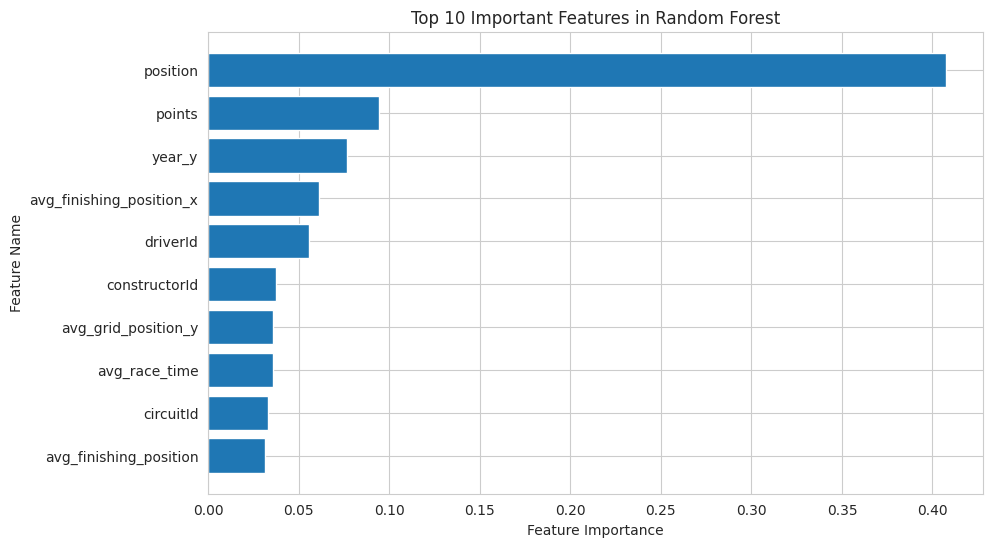

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot
plt.figure(figsize=(10,6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], feature_importance[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features in Random Forest")
plt.gca().invert_yaxis()
plt.show()


In [2]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost R² Score: {r2_xgb:.2f}")


NameError: name 'X_train' is not defined

In [3]:
#subproblem 5
import pandas as pd

# Load datasets
drivers_df = pd.read_csv('drivers.csv')
constructors_df = pd.read_csv('constructors.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')
constructor_standings_df = pd.read_csv('constructor_standings.csv')
final_df = pd.read_csv('final_df.csv')  # Merged dataset


# Choose two drivers to swap
driver_1 = 'Max Verstappen'  # From Red Bull
driver_2 = 'Lewis Hamilton'  # From Mercedes

# Get driver IDs (using str.contains for flexible matching)
driver_1_id = drivers_df[drivers_df['surname'].str.contains(driver_1.split()[-1])]['driverId'].values[0]  # Get ID using surname
driver_2_id = drivers_df[drivers_df['surname'].str.contains(driver_2.split()[-1])]['driverId'].values[0]  # Get ID using surname

# Get constructor IDs for Red Bull and Mercedes
red_bull_id = constructors_df[constructors_df['name'] == 'Red Bull']['constructorId'].values[0]
mercedes_id = constructors_df[constructors_df['name'] == 'Mercedes']['constructorId'].values[0]

# Swap constructor affiliations
final_df.loc[final_df['driverId'] == driver_1_id, 'constructorId'] = mercedes_id
final_df.loc[final_df['driverId'] == driver_2_id, 'constructorId'] = red_bull_id

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define X and y
# The column name is likely 'avg_finishing_position' or 'positionOrder'
# Replace 'finishing_position' with the actual target column name
X = final_df.drop(columns=['positionOrder'])  # Features
y = final_df['positionOrder']                # Target

# Train Random Forest Model (Use Grid Search Optimized Model)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X, y)

# Predict finishing positions for swapped drivers
final_df['new_predicted_position'] = rf_model.predict(X)

# Compare Old vs. New Positions
impact_df = final_df[['driverId', 'positionOrder', 'new_predicted_position']] # Also change here
print(impact_df.head(10))

   driverId  positionOrder  new_predicted_position
0         1              1                1.673212
1         1              5                3.307176
2         1             13                5.914808
3         1              3                2.690968
4         1              2                4.534228
5         1              1                2.530088
6         1             19               14.196261
7         1             10                6.472319
8         1              1                2.895735
9         1              1                3.195506


In [5]:
# Update driver points based on new predictions
driver_standings_df['new_points'] = driver_standings_df['driverId'].map(
    final_df.groupby('driverId')['new_predicted_position'].mean()
)

# Sort drivers based on new points
driver_standings_df = driver_standings_df.sort_values('new_points', ascending=True)

print("\n🔹 Updated Driver Standings:\n", driver_standings_df.head(10))



🔹 Updated Driver Standings:
        driverStandingsId  raceId  driverId  points  position positionText  \
23190              49452     773       591     6.0        14           14   
22807              49085     768       591     6.0         7            7   
22876              49152     769       591     6.0         8            8   
23360              49618     775       591     6.0        15           15   
22948              49221     770       591     6.0         9            9   
23107              49369     772       591     6.0        13           13   
23024              49293     771       591     6.0        12           12   
23273              49535     774       591     6.0        14           14   
30633              67307     939         1   252.0         1            1   
30332              66988     916         1   316.0         1            1   

       wins  new_points  
23190     0    3.794134  
22807     0    3.794134  
22876     0    3.794134  
23360     0    3.7

In [6]:
# Update constructor points based on new results
constructor_standings_df['new_points'] = constructor_standings_df['constructorId'].map(
    final_df.groupby('constructorId')['new_predicted_position'].mean()
)

# Sort constructors by points
constructor_standings_df = constructor_standings_df.sort_values('new_points', ascending=True)

print("\n🔹 Updated Constructor Standings:\n", constructor_standings_df.head(10))



🔹 Updated Constructor Standings:
       constructorStandingsId  raceId  constructorId  points  position  \
3868                    8692      10             23   114.0         1   
3674                    4038       1             23    18.0         1   
3807                    8562       3             23    36.0         1   
3817                    8582       4             23    50.0         1   
3818                    8592       5             23    68.0         1   
3928                    8762      16             23   161.0         1   
3925                    8752      15             23   156.0         1   
3837                    8672       6             23    86.0         1   
3908                    8732      14             23   153.0         1   
8383                   13918      17             23   172.0         1   

     positionText  wins  new_points  
3868            1     6    3.468417  
3674            1     1    3.468417  
3807            1     2    3.468417  
3817     

In [ ]:
#"Your session crashed after using all available RAM." dont run
import matplotlib.pyplot as plt
import seaborn as sns

# Merge with drivers_df to get driver names
impact_df = impact_df.merge(drivers_df[['driverId', 'forename', 'surname']], on='driverId', how='left')
impact_df['driver_name'] = impact_df['forename'] + ' ' + impact_df['surname']

# Merge with final_df to get constructorId
impact_df = impact_df.merge(final_df[['driverId', 'constructorId']], on='driverId', how='left')

# Assign constructor colors (example, you can customize)
constructor_colors = {'Red Bull': 'darkblue', 'Mercedes': 'cyan'}
# Assuming 'constructorId' exists in your dataframe:
impact_df['constructor_color'] = impact_df['constructorId'].map(constructor_colors)

plt.figure(figsize=(12, 6))
# Old position in gray
sns.barplot(x='driver_name', y='positionOrder', data=impact_df, color='lightgray', label='Original Position')
# New position colored by constructor
sns.barplot(x='driver_name', y='new_predicted_position', data=impact_df, hue='constructorId', palette=constructor_colors, label='Predicted Position')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Driver")
plt.ylabel("Finishing Position")
plt.title("Driver Position Changes After Swap")
plt.legend()
plt.tight_layout()
plt.show()

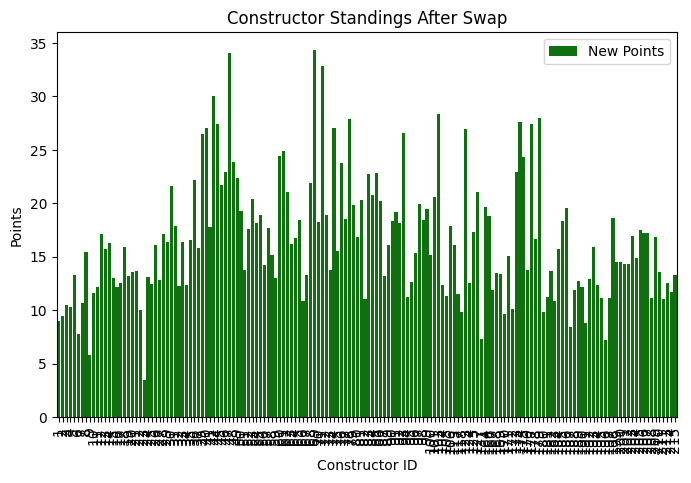

In [7]:
# Plot Constructor Points Before vs. After
plt.figure(figsize=(8, 5))
sns.barplot(x=constructor_standings_df['constructorId'], y=constructor_standings_df['new_points'], color='green', label="New Points")
plt.xticks(rotation=90)
plt.xlabel("Constructor ID")
plt.ylabel("Points")
plt.title("Constructor Standings After Swap")
plt.legend()
plt.show()


In [ ]:
'''Finishing Positions Shift:
If Hamilton in Red Bull consistently finishes higher than he did at Mercedes, it suggests that Red Bull's car is significantly stronger than Mercedes'.
If Verstappen in Mercedes finishes lower than in Red Bull, it highlights how much the car influences driver performance.
If the changes are minor, it suggests driver skill compensates for car differences.

Points Comparison:
If Hamilton’s points increase, this means Red Bull would have helped him perform better.
If Verstappen’s points drop, this confirms that Mercedes currently has a weaker car.

Conclusion: A dominant car like Red Bull's may boost a driver’s performance more than skill alone.
'''

In [8]:
#subproblem 6
import pandas as pd

# Load datasets
drivers_df = pd.read_csv('drivers.csv')  # Contains driver info
constructors_df = pd.read_csv('constructors.csv')  # Team details
results_df = pd.read_csv('results.csv')  # Race results with team & driver

# Merge relevant data
driver_transitions = results_df[['driverId', 'constructorId', 'raceId']].merge(
    drivers_df[['driverId', 'surname']], on='driverId'
).merge(
    constructors_df[['constructorId', 'name']], on='constructorId'
)

# Sort by raceId to track movements over time
driver_transitions = driver_transitions.sort_values(by=['driverId', 'raceId'])

print(driver_transitions.head(10))  # Preview transitions


      driverId  constructorId  raceId   surname     name
7572         1              1       1  Hamilton  McLaren
7579         1              1       2  Hamilton  McLaren
7598         1              1       3  Hamilton  McLaren
7616         1              1       4  Hamilton  McLaren
7641         1              1       5  Hamilton  McLaren
7664         1              1       6  Hamilton  McLaren
7685         1              1       7  Hamilton  McLaren
7708         1              1       8  Hamilton  McLaren
7730         1              1       9  Hamilton  McLaren
7733         1              1      10  Hamilton  McLaren


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


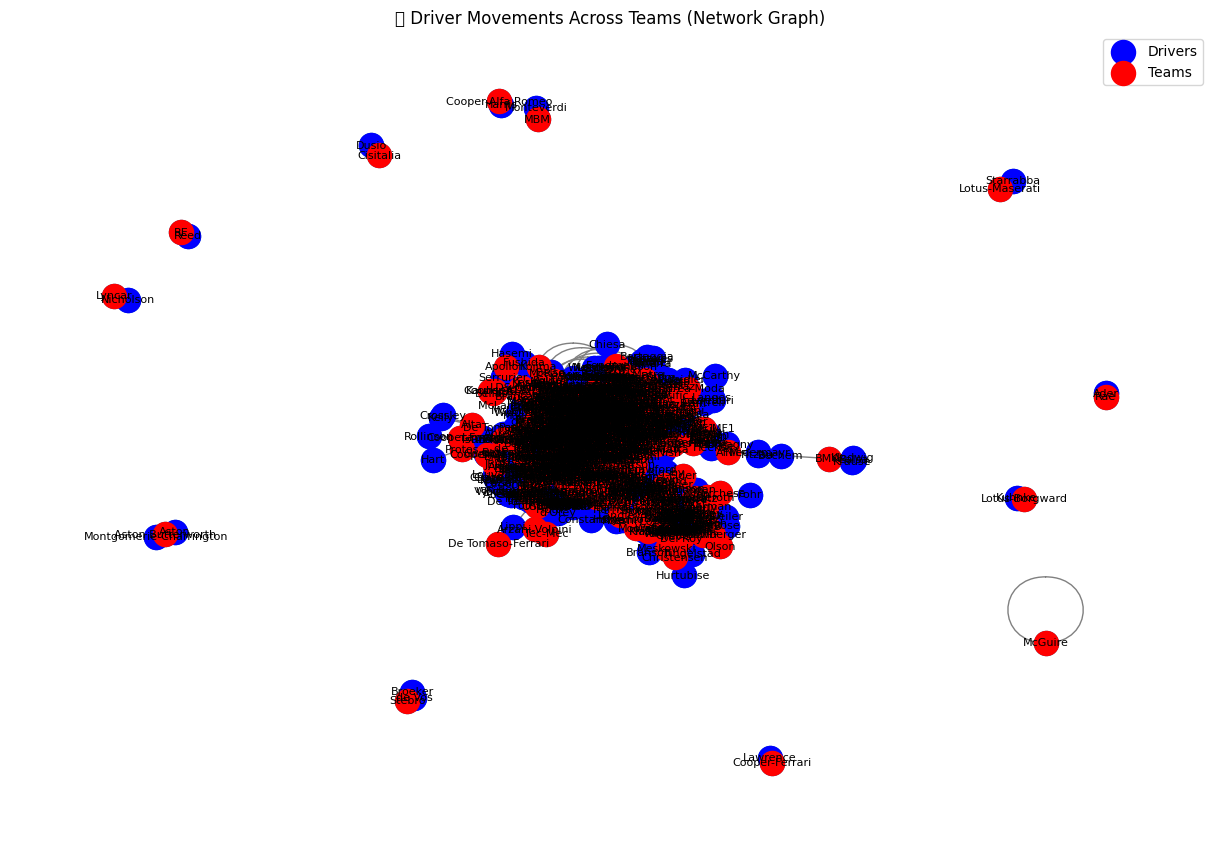

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.Graph()

# Add nodes (drivers & teams)
for _, row in driver_transitions.iterrows():
    G.add_node(row['surname'], type='driver')
    G.add_node(row['name'], type='team')
    G.add_edge(row['surname'], row['name'])  # Connect driver to team

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Node positioning
nx.draw(G, pos, with_labels=True, node_size=300, font_size=8, edge_color='gray')

# Highlight driver vs team nodes
driver_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'driver']
team_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'team']

nx.draw_networkx_nodes(G, pos, nodelist=driver_nodes, node_color='blue', label="Drivers")
nx.draw_networkx_nodes(G, pos, nodelist=team_nodes, node_color='red', label="Teams")

plt.title("🔗 Driver Movements Across Teams (Network Graph)")
plt.legend()
plt.show()


In [10]:
#subproblem 7
import pandas as pd

# Load datasets
results_df = pd.read_csv('results.csv')
constructor_standings_df = pd.read_csv('constructor_standings.csv')
circuits_df = pd.read_csv('circuits.csv')

# Merge relevant data
team_performance = results_df[['raceId', 'constructorId', 'positionOrder', 'points']].merge(
    constructor_standings_df[['constructorId', 'raceId', 'points']], on=['constructorId', 'raceId'], suffixes=('_driver', '_team')
)

print(team_performance.head(10))  # Preview dataset


   raceId  constructorId  positionOrder  points_driver  points_team
0      18              1              1           10.0         14.0
1      18              2              2            8.0          8.0
2      18              3              3            6.0          9.0
3      18              4              4            5.0          5.0
4      18              1              5            4.0         14.0
5      18              3              6            3.0          9.0
6      18              5              7            2.0          2.0
7      18              6              8            1.0          1.0
8      18              2              9            0.0          8.0
9      18              4             12            0.0          5.0


In [11]:
# Calculate podium finishes (positions 1, 2, 3)
podium_finishes = results_df[results_df['positionOrder'] <= 3].groupby('constructorId').size()

# Calculate total races per team
total_races = results_df.groupby('constructorId').size()

# Compute success rate
success_rate = (podium_finishes / total_races) * 100
success_rate = success_rate.fillna(0)  # Handle missing values

# Convert to DataFrame
success_rate_df = success_rate.reset_index()
success_rate_df.columns = ['constructorId', 'success_rate']
print(success_rate_df.head())


   constructorId  success_rate
0              1     26.417057
1              2     12.142857
2              3     18.735084
3              4     13.087675
4              5      0.559701


In [13]:
# Merge circuit data
team_circuit_performance = team_performance.merge(
    dfs["races"][['raceId', 'circuitId']], on='raceId' # Use dfs["races"] instead of results_df
).merge(
    circuits_df[['circuitId', 'name']], on='circuitId'
)

# Compute success rate per circuit
circuit_success_rate = team_circuit_performance.groupby(['constructorId', 'name']).agg(
    wins=('points_driver', lambda x: (x > 0).sum()),
    total_races=('raceId', 'count')
)

circuit_success_rate['success_rate'] = (circuit_success_rate['wins'] / circuit_success_rate['total_races']) * 100
circuit_success_rate.reset_index(inplace=True)

print(circuit_success_rate.head())  # Success rate by circuit

   constructorId                                  name  wins  total_races  \
0              1               Adelaide Street Circuit    10           22   
1              1        Albert Park Grand Prix Circuit    34           48   
2              1         Autodromo Enzo e Dino Ferrari    38           60   
3              1  Autodromo Internazionale del Mugello     1            2   
4              1          Autodromo Nazionale di Monza    56          113   

   success_rate  
0     45.454545  
1     70.833333  
2     63.333333  
3     50.000000  
4     49.557522  


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


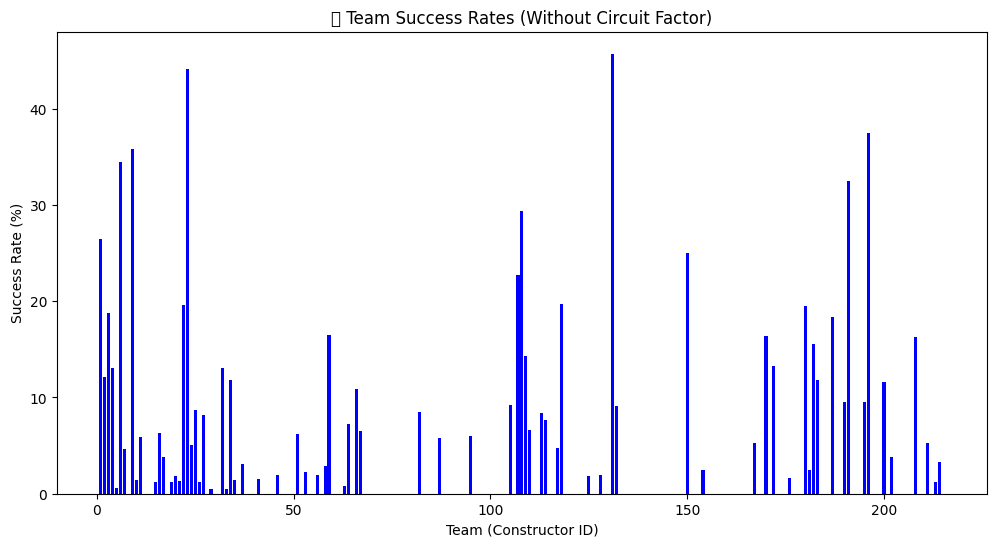

In [14]:
import matplotlib.pyplot as plt

# Plot general success rates
plt.figure(figsize=(12, 6))
plt.bar(success_rate_df['constructorId'], success_rate_df['success_rate'], color='blue')
plt.xlabel("Team (Constructor ID)")
plt.ylabel("Success Rate (%)")
plt.title("📊 Team Success Rates (Without Circuit Factor)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


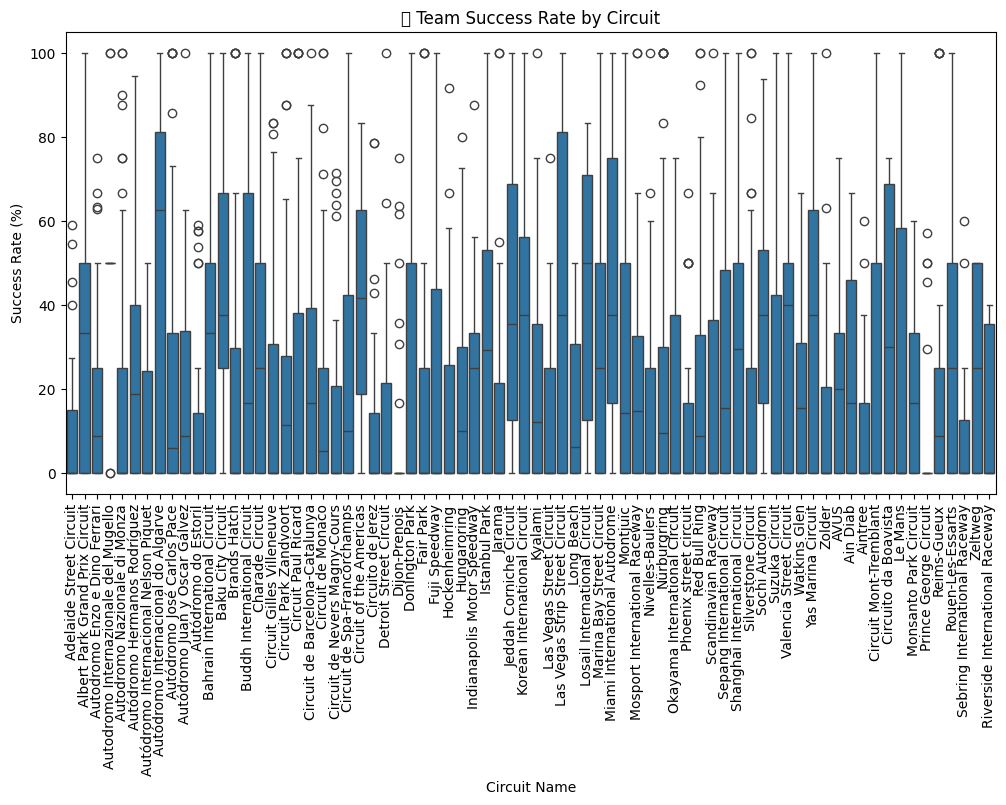

In [15]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='name', y='success_rate', data=circuit_success_rate)
plt.xticks(rotation=90)
plt.xlabel("Circuit Name")
plt.ylabel("Success Rate (%)")
plt.title("📊 Team Success Rate by Circuit")
plt.show()


In [17]:
#subproblem 8
import pandas as pd

# Load datasets
results_df = pd.read_csv('results.csv')
drivers_df = pd.read_csv('drivers.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')

# Merge driver information
driver_performance = results_df[['raceId', 'driverId', 'positionOrder', 'points']].merge(
    drivers_df[['driverId', 'surname']], on='driverId'
)

print(driver_performance.head(10))  # Preview dataset


   raceId  driverId  positionOrder  points     surname
0      18         1              1    10.0    Hamilton
1      18         2              2     8.0    Heidfeld
2      18         3              3     6.0     Rosberg
3      18         4              4     5.0      Alonso
4      18         5              5     4.0  Kovalainen
5      18         6              6     3.0    Nakajima
6      18         7              7     2.0    Bourdais
7      18         8              8     1.0   Räikkönen
8      18         9              9     0.0      Kubica
9      18        10             10     0.0       Glock


In [18]:
# Compute average finishing position
avg_finish = driver_performance.groupby('driverId')['positionOrder'].mean()

# Compute standard deviation of finishing positions
std_dev_finish = driver_performance.groupby('driverId')['positionOrder'].std()

# Compute percentage of top 5 finishes
top_5_finishes = driver_performance[driver_performance['positionOrder'] <= 5].groupby('driverId').size()
total_races = driver_performance.groupby('driverId').size()

top_5_percentage = (top_5_finishes / total_races) * 100
top_5_percentage = top_5_percentage.fillna(0)  # Handle missing values

# Combine into a DataFrame
consistency_df = pd.DataFrame({
    'driverId': avg_finish.index,
    'avg_position': avg_finish.values,
    'std_dev_position': std_dev_finish.values,
    'top_5_percentage': top_5_percentage.values
}).merge(drivers_df[['driverId', 'surname']], on='driverId')

# Sort by consistency
consistency_df = consistency_df.sort_values(by='std_dev_position', ascending=True)  # Lower std_dev is better

print(consistency_df.head(10))  # Preview consistent drivers


     driverId  avg_position  std_dev_position  top_5_percentage  \
143       144     32.000000          0.000000               0.0   
724       725     17.000000          0.000000               0.0   
399       400     11.000000          0.000000               0.0   
131       132     30.000000          0.000000               0.0   
133       134     38.833333          0.408248               0.0   
197       198     27.666667          0.577350               0.0   
241       242     27.666667          0.577350               0.0   
291       292     13.333333          0.577350               0.0   
141       142     33.615385          0.650444               0.0   
460       461     24.500000          0.707107               0.0   

            surname  
143         Hattori  
724       Abecassis  
399        Lawrence  
131           Amati  
133       Bertaggia  
197  Villeneuve Sr.  
241          Galica  
291          Keizan  
141          Chaves  
460        Schiller  


In [19]:
# Define thresholds
consistent_drivers = consistency_df[consistency_df['std_dev_position'] < 3]  # Low variation
fluctuating_drivers = consistency_df[consistency_df['std_dev_position'] > 7]  # High variation

print("🏎️ Most Consistent Drivers:")
print(consistent_drivers[['surname', 'avg_position', 'std_dev_position', 'top_5_percentage']].head(10))

print("\n🔄 Most Fluctuating Drivers:")
print(fluctuating_drivers[['surname', 'avg_position', 'std_dev_position', 'top_5_percentage']].head(10))


🏎️ Most Consistent Drivers:
            surname  avg_position  std_dev_position  top_5_percentage
143         Hattori     32.000000          0.000000               0.0
724       Abecassis     17.000000          0.000000               0.0
399        Lawrence     11.000000          0.000000               0.0
131           Amati     30.000000          0.000000               0.0
133       Bertaggia     38.833333          0.408248               0.0
197  Villeneuve Sr.     27.666667          0.577350               0.0
241          Galica     27.666667          0.577350               0.0
291          Keizan     13.333333          0.577350               0.0
141          Chaves     33.615385          0.650444               0.0
460        Schiller     24.500000          0.707107               0.0

🔄 Most Fluctuating Drivers:
            surname  avg_position  std_dev_position  top_5_percentage
121         Capelli     16.816327          7.004192          8.163265
588          Chiron     14.058824

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


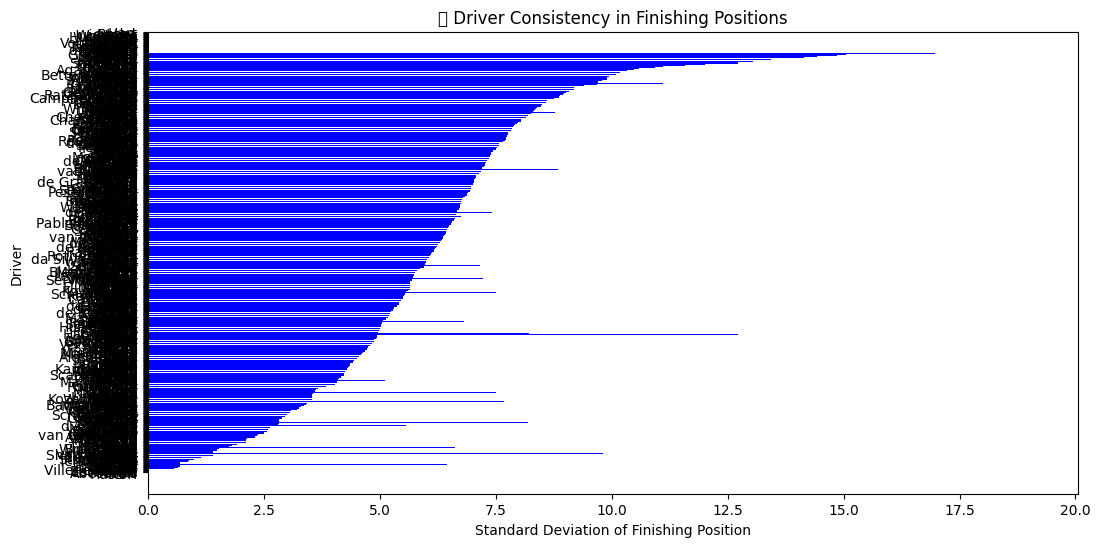

In [20]:
import matplotlib.pyplot as plt

# Sort by consistency
consistency_df = consistency_df.sort_values(by='std_dev_position')

# Plot standard deviation of finishing positions
plt.figure(figsize=(12, 6))
plt.barh(consistency_df['surname'], consistency_df['std_dev_position'], color='blue')
plt.xlabel("Standard Deviation of Finishing Position")
plt.ylabel("Driver")
plt.title("📊 Driver Consistency in Finishing Positions")
plt.show()


<ipython-input-21-70464f96d21d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=consistency_df['surname'], x=consistency_df['top_5_percentage'], palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


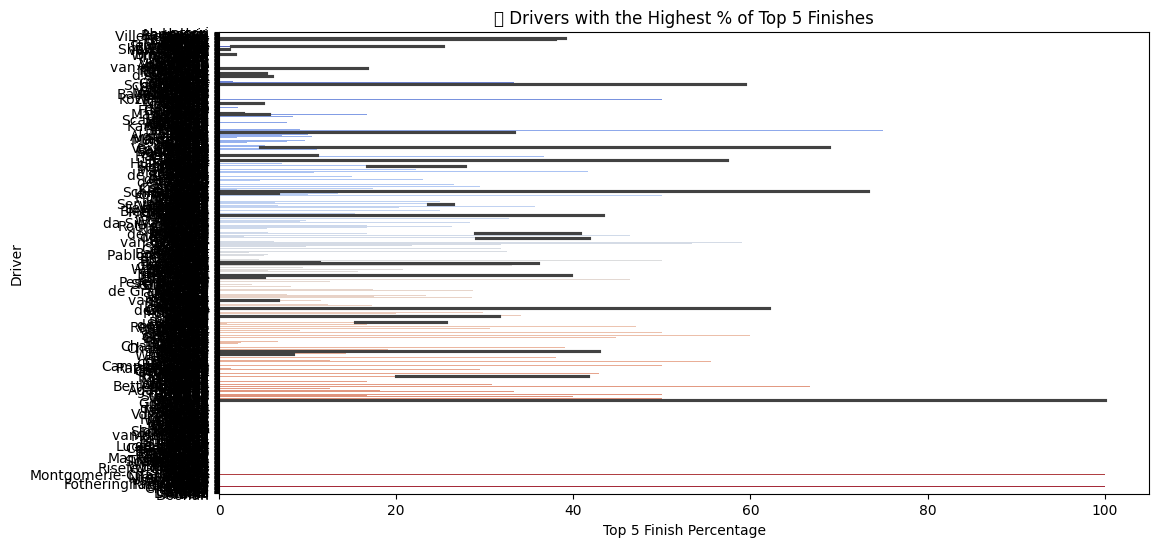

In [21]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(y=consistency_df['surname'], x=consistency_df['top_5_percentage'], palette='coolwarm')
plt.xlabel("Top 5 Finish Percentage")
plt.ylabel("Driver")
plt.title("📊 Drivers with the Highest % of Top 5 Finishes")
plt.show()


In [1]:
#Gaussian NB
import pandas as pd

# Load dataset
file_path = "final_df.csv"
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())
print(df.info())


   Unnamed: 0  driverId  constructorId  year_x  avg_finishing_position_x  \
0           0         1              1    2007                  3.941176   
1           1         1              1    2007                  3.941176   
2           2         1              1    2007                  3.941176   
3           3         1              1    2007                  3.941176   
4           4         1              1    2007                  3.941176   

   total_podiums_x  total_wins_x  avg_grid_position_x  fastest_lap_count_x  \
0               12             4             2.588235                    0   
1               12             4             2.588235                    0   
2               12             4             2.588235                    0   
3               12             4             2.588235                    0   
4               12             4             2.588235                    0   

   avg_finishing_position_y  ...  fastest_lap_count_y  positionOrder  year

In [2]:
from sklearn.preprocessing import LabelEncoder

# Drop unnecessary columns (e.g., names, IDs if present)
df = df.drop(columns=['raceId', 'driverId', 'constructorId'], errors='ignore')

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for future use

# Define features and target
X = df.drop(columns=['positionOrder'], errors='ignore')  # Features
y = df['positionOrder']  # Target (finishing position)

print("Feature Columns:", X.columns)


Feature Columns: Index(['Unnamed: 0', 'year_x', 'avg_finishing_position_x', 'total_podiums_x',
       'total_wins_x', 'avg_grid_position_x', 'fastest_lap_count_x',
       'avg_finishing_position_y', 'total_podiums_y', 'total_wins_y',
       'fastest_lap_count_y', 'year_y', 'circuitId', 'avg_race_time',
       'avg_grid_position_y', 'avg_finishing_position', 'overtaking_index',
       'points', 'position'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")


Training set size: 69297 | Test set size: 17325


In [4]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"📊 Model Performance:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ R² Score: {r2:.2f}")
print(f"✅ Accuracy: {accuracy:.2%}")


📊 Model Performance:
✅ Mean Absolute Error (MAE): 6.59
✅ R² Score: -0.39
✅ Accuracy: 8.664%


In [7]:
#SVB
import pandas as pd

# Load dataset
file_path = "final_df.csv"
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())
print(df.info())


   Unnamed: 0  driverId  constructorId  year_x  avg_finishing_position_x  \
0           0         1              1    2007                  3.941176   
1           1         1              1    2007                  3.941176   
2           2         1              1    2007                  3.941176   
3           3         1              1    2007                  3.941176   
4           4         1              1    2007                  3.941176   

   total_podiums_x  total_wins_x  avg_grid_position_x  fastest_lap_count_x  \
0               12             4             2.588235                    0   
1               12             4             2.588235                    0   
2               12             4             2.588235                    0   
3               12             4             2.588235                    0   
4               12             4             2.588235                    0   

   avg_finishing_position_y  ...  fastest_lap_count_y  positionOrder  year

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop unnecessary columns
df = df.drop(columns=['raceId', 'driverId', 'constructorId'], errors='ignore')

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for future use

# Define features and target
X = df.drop(columns=['positionOrder'], errors='ignore')  # Features
y = df['positionOrder']  # Target (finishing position)

# Standardize features for SVR (important for performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature Columns:", X.columns)


Feature Columns: Index(['Unnamed: 0', 'year_x', 'avg_finishing_position_x', 'total_podiums_x',
       'total_wins_x', 'avg_grid_position_x', 'fastest_lap_count_x',
       'avg_finishing_position_y', 'total_podiums_y', 'total_wins_y',
       'fastest_lap_count_y', 'year_y', 'circuitId', 'avg_race_time',
       'avg_grid_position_y', 'avg_finishing_position', 'overtaking_index',
       'points', 'position'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")


Training set size: 69297 | Test set size: 17325


In [12]:
from sklearn.svm import SVR

# Initialize SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)


In [25]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate accuracy within a tolerance (e.g., +/- 1 position)
tolerance = 1  # Define your tolerance
accurate_predictions = np.sum(np.abs(y_test - y_pred) <= tolerance)
total_predictions = len(y_test)
accuracy_within_tolerance = accurate_predictions / total_predictions

print(f"📊 SVR Model Performance:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ R² Score: {r2:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ Accuracy within tolerance of +/- {tolerance}: {accuracy_within_tolerance:.2%}")

📊 SVR Model Performance:
✅ Mean Absolute Error (MAE): 4.33
✅ R² Score: 0.35
✅ Root Mean Squared Error (RMSE): 6.06
✅ Accuracy within tolerance of +/- 1: 22.22%


In [15]:
# Convert continuous predictions to integer positions (rounded)
y_pred_rounded = np.round(y_pred).astype(int)


In [16]:
import numpy as np

# Rank positions (1st = best, etc.)
sorted_indices = np.argsort(y_pred)  # Get indices of sorted predictions
final_positions = np.zeros_like(y_pred_rounded)

# Assign ranks (1st place gets rank 1, etc.)
for rank, index in enumerate(sorted_indices, start=1):
    final_positions[index] = rank


In [22]:
# Get test drivers (assuming we have 'driverId' in original df)
#X_test was scaled and is no longer a dataframe
#resetting the index of df and creating a list of index from X_test
#X_test_index = X_test.index # Added this line to define X_test_index  <- This line caused the error
#X_test_index = y_test.index # Use original index from y_test
#test_driver_ids = df.reset_index().iloc[X_test_index]['driverId'].values  # Adjust if needed

# Load the original dataframe with 'driverId'
original_df = pd.read_csv("final_df.csv")  # Replace "final_df.csv" with your original file path

test_driver_ids = original_df.iloc[y_test.index]['driverId'].values  # Access 'driverId' from the original dataframe

# Create a dataframe with predicted standings
predicted_results = pd.DataFrame({
    'Driver ID': test_driver_ids,
    'Predicted Position': final_positions
})

# Sort by predicted position
predicted_results = predicted_results.sort_values(by="Predicted Position")

print(predicted_results)

       Driver ID  Predicted Position
184           57                   1
1105          71                   2
13203        578                   3
2644          71                   4
1092         830                   5
...          ...                 ...
13992        152               17321
7176         162               17322
3260         114               17323
13050        164               17324
8588          88               17325

[17325 rows x 2 columns]
